# Fitting a Linear Encoding Model to Miniscope Data

Now that we've learned the basics of ridge regression, lets use it to build an encoding model with calcium imaging data. We will make use of scikit-learn, a popular machine learning library, to handle the regression fitting and crossvalidation.

#### The dataset

Neural activity was recorded from mouse anterior cingulate cortex (ACC) with a head-mounted miniscope. During the miniscope recording, the mouse performed a two-alternative forced choice (2AFC) task. The mouse had to discriminate between high-frequency (> 12 Hz) and low-frequency (< 12 Hz) auditory click trains. Depending on whether the stimulus was above or below this threshold, the mouse must poke its nose into the left or right spout to receive a water reward. The recording chamber was equipped with high speed cameras to track animal movements.

Data was collected and preprocessed by Lukas Oesch in the Churchland Lab.

#### Load the data

In [14]:
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from tqdm import tqdm

import encoding_tools

data_path = encoding_tools.download_neural_data("miniscope") #Download data
design_matrix, Y_raw_fluorescence, neuron_footprints, frames_per_trial, frame_rate, aligned_segment_start = encoding_tools.load_miniscope(data_path)

### Show two example neurons in the field of view

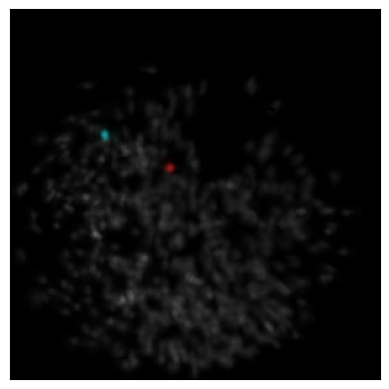

In [2]:
encoding_tools.overlay_neurons(neuron_footprints, 56, 12, 12) #Pass the neuron ids for the red, green and blue channel

#### Descriptions of the variables we loaded

- **design_matrix**: This is the heart of the encoding model we are going to build. It contains a set of task and movement variables aligned to four distinct phases of the task, size is [number of total frames, regressor number]. It is equivalent to the matrix X from the previous notebook.

- **Y_raw_fluorescence**: The fluorescence traces from all the neurons recorded aligned to the same task phases as the task- and movement variables, size is [number of total frames, number of neurons]

- **neuron_footprints**: The spatial filters for the recorded neurons, size is [300 pixels, 300 pixels, neuron number].

- **frames_per_trial**: The number of frames per trial.

- **frame_rate**: The acquisition frame rate for the miniscope data.

- **aligned_segment_start**: Marks the frames where the activity was aligned to a new task event. These also mark different task phases: Timepoints 0 to `aligned_segment_start[0]` contains the 1 second prior to trial initiation, the next phase is the 1 second from stimulus onset followed by action phase spanning from 200 ms before to 300 ms after movement onset and finally the outcome phase with 2 seconds after outcome presentation. The reason why the trial is split up into these phases is that there are variable delays before and after stimulus presentation and the choice report also happens at different speed.
 


## Why build an encoding model?
Ultimately, we would like to understand how different task variables (eg. stimulus, reward, and choice) and animal behaviors (eg. head orientation and DLC labels) affect neural activity. Ecoding models help us answer this by finding the relationship between movements and task variables ($X$) and neural activity ($Y$). There are many ways to do this, but we will chose to model a linear relationship between our predictor variables and the neural activity:

$$
Y = \beta X
$$

As we did in the previous notebook, here we will solve for $\beta$ using ridge regression. We will refer to the matrix $X$ as the *design matrix*. The design matrix is coded to contain all of the variables that we would like to predict neural activity with.

Below is a figure from [Musall *et al* 2022](https://www.nature.com/articles/s41593-022-01245-9) that illustrates one possible design matrix. Animal movements (such as licking) and task variables (such as the stimulus) are coded into the design matrix. Other variables including pupil diameter, trial initiation tone, and hindlimb movements are also coded into the design matrix, but are not depicted here.

<div>
<img src="images/design_matrix.PNG" width="500"/>
</div>

Within the design matrix, multiple time-shifted regressors for a particular variable are often included. This allows us to predict neural activity at a given time while making use of events that may have occurred before or after the exact moment in time we are trying to predict neural activity for. Here are some examples:
- Stimulus related activity will appear with some delay, as shown in the bottom of the figure. So we want to allow the stimulus to affect neural activity after it comes on
- Movements tend to have some "preparatory" activity that preceeds the actual execution of the movement. So we want a movement to be able to explain neural activity *before* it has occurred.

**Coding the design matrix this way allows us to break free from the assumption that a particular event could only influence neural activity at the exact moment that it occurs**.






## Exercise 1: The structure of the design matrix

Lets start by looking at some of the task variables inside the design matrix:

<ul>
    <li>time (somewhat like an intercept term, explains fluctuations that happen every trial)</li>
    <li>choice (left = 0, right = 1)</li>
    <li>stimulus strength</li>
    <li>outcome (incorrect = 0, correct = 1)</li>
    <li>previous choice  (left = 0, right = 1)</li>
    <li>previous outcome (incorrect = 0, correct = 1)</li>
</ul> 

**Below, we will visualize part of the design matrix**

Plotting the following regressors: ['time_t0', 'choice_t0', 'stim_strength_t0', 'outcome_t0', 'previous_choice_t0', 'previous_outcome_t0']
Full design matrix shape is 47196 frames by 1258 regressors.


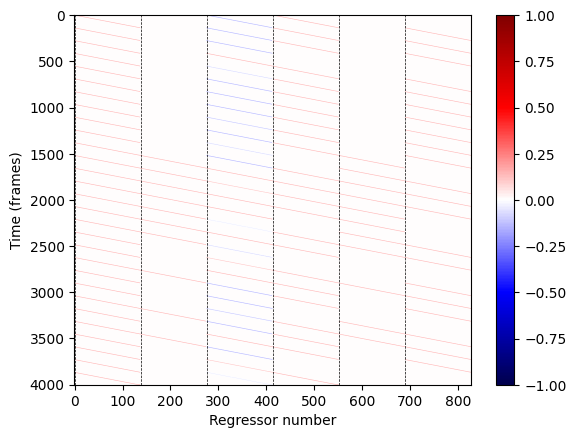

In [3]:
N_TRIALS_TO_PLOT = 29 # starting from first trial
N_REGRESSORS_TO_PLOT = 6 # starting from first regressor

#Print some of the keys of the design matrix
regs_2_plot = design_matrix.keys()[np.arange(0,N_REGRESSORS_TO_PLOT * frames_per_trial, frames_per_trial)].tolist()
print(f'Plotting the following regressors: {regs_2_plot}')
print(f'Full design matrix shape is {np.array(design_matrix).shape[0]} frames by {np.array(design_matrix.shape[1])} regressors.')


plt.figure()
plt.imshow(np.array(design_matrix)[:N_TRIALS_TO_PLOT * frames_per_trial,:N_REGRESSORS_TO_PLOT * frames_per_trial], aspect='auto', cmap='seismic')
#use np.array() on the design_matrix to be able to index numerically instead of by key
for k in range(N_REGRESSORS_TO_PLOT):
    plt.axvline(k * frames_per_trial, color='k', linestyle='--', linewidth=0.5)
    
plt.colorbar()
plt.xlabel('Regressor number')
plt.ylabel('Time (frames)')
plt.show()

#### Try to answer the following questions based on the plot above
- What do the black dashed lines denote?
- Why do we need many columns to represent one variable (such as choice)?
- On the left side of the figure, why is the first column within the dashed lines full 1's on the diagonal?
- Why are there blue/negative values in the third column?

## Exercise 2: Estimating the regularization strength of the model

As you have seen in the previous notebook, $\alpha$ controls the shrinkage of the regressor weights and is critical to prevent overfitting. In this notebook we will use the `sklearn.linear_model.RidgeCV` class. RidgeCV searches through a grid of provided candidate $\alpha$ values and determines the best one using *leave-one-out* cross-validation.

In the following exercise you will be asked to:
<ol>
    <li> Choose appropriate parameters <strong>fit_intercept</strong> and <strong>alphas_per_target</strong> for RidgeCV.</li>
    <li> Perform the grid search.</li>
    <li> Retrieve the found regularization strengths as <strong>alphas</strong>.</li>
</ol>

### First, preprocess the data

Here, we will set the inputs and outputs up for the following hyperparameter optimization and the model fitting and performance evaluation. We will need to z-score the response matrix, Y_raw_fluorescence, and the design_matrix as well. The latter one is extremely important to make sure that the different regressors are measured on the same scale, so all regressors get a fair chance to explain variance. However, here, we choose not to z-score the binary task variables because leaving them in their binary form preserves the interpretability of the model. <br>

In [4]:
#z-score the response matrix
from scipy.stats import zscore
Y = zscore(Y_raw_fluorescence, axis=0)

#z-score the respective column of the design matrix
scaler_obj = encoding_tools.standardize_x_cols(column_idx=np.arange(832, 1258)).fit(design_matrix) #Cols 0:827 are task vars, cols 828:832 are head orientation
X = scaler_obj.transform(design_matrix)
#Note: this class is defined in utils. It contains a fit and transform method, similar to StandardScaler from sklearn.preprocessing
#We'll get back to this below

print(X.shape)
print(Y.shape)

(47196, 1258)
(47196, 555)


Now, we will use `sklearn.linear_model.RidgeCV` to find the best values of $\alpha$. You will need to pass the proper values for the following keyword arguments to `RidgeCV`:

```
alphas
fit_intercept
alpha_per_target
scoring
store_cv_values
```
You will likely want to look at [the sklearn RidgeCV documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html) to determine what you should pass.



In [5]:
alpha_test_range = 10**np.linspace(-10,9,50) #Get search values for alpha on log scale

# 1. Define the RidgeCV paramters fit_intercept and alphas_per_target and explain why you chose them

##########################-----Solution----############3
fit_intercept = False # because we already mean centered the data
alpha_per_target = True #Allow every neuron to be regularized individualy for better model performance
####################################################################################

# 2. Perform the grid search on the provided arrays X and Y. Use the RidgeCV function. SKLearn documentation will be helpful here.

# TODO: Insert your code here
from sklearn.linear_model import RidgeCV
#########-------------Solution----------###############################################################
ridge_grid_search = RidgeCV(alphas=alpha_test_range,
                            fit_intercept=fit_intercept,
                            alpha_per_target=alpha_per_target,
                            scoring='r2',
                            store_cv_values=True)
ridge_grid_search.fit(X,Y)
alphas = ridge_grid_search.alpha_
#######################################################################################################

### Plot histogram of the best alpha values for the all of the neurons

Text(0, 0.5, 'Count')

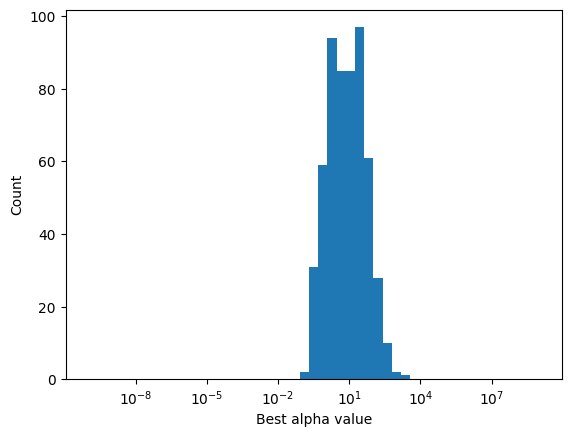

In [6]:
fig,ax = plt.subplots()
ax.hist(alphas, bins=alpha_test_range)
ax.set_xscale('log')
ax.set_xlabel('Best alpha value')
ax.set_ylabel('Count')

## Exercise 3: Assemble a pipeline for data preprocessing and model fitting with the found regularization strengths, alpha

For this exercise you will use `sklearn.pipeline.Pipeline` ([docs here](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)) to standardize the data, fit ridge models for the 10 splits of cross-validation, and evaluate the performance of each of them. 

- Create a `Pipeline` with two layers:
1. Use `encoding_tools.standardize_x_cols` to z score columns of the design matrix. Name this layer of the pipeline `scaler`.
2. Use `sklearn.linear_models.Ridge` to create the ridge regression model. Name this layer of the pipeline `ridge`.

Store the pipeline with the name `pipe`.

- Use the pipeline's `.fit()` method to fit the model on the training data, then `.predict()` to generate predictions with the testing data. We will use `sklearn.metrics.r2_score` to compute the $R^2$ on the held out data.

In [7]:
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

N_FOLDS = 10
X = np.array(design_matrix) #convert to array 

kf = KFold(n_splits=N_FOLDS, shuffle=True) 
custom_scaler = encoding_tools.standardize_x_cols(column_idx = np.arange(832, 1258)) 
ridge_model = Ridge(alpha=alphas, fit_intercept=fit_intercept)

#Set up the lists for beta weights and coefficient of determination of all the 10 models
betas = []
r_squared = []

# 1. Create the pipeline for the fitting below. The pipeline should contain a 'scaler' step that calls standardize_x_cols
#    and a ridge step that fits the model. Pipelines are nice because now the data standardization happens within each fold, which is best practice.

###########################-----Solution-------------------####################
pipe = Pipeline(steps=[('scaler', custom_scaler),
                       ('ridge', ridge_model)])
#####################################################################

for train_index, test_index in kf.split(X, Y): #iterate over cv folds
    # 2. Fit the training data sets using the pipleline and save the result as "fits". Then predict the unseen testing data
    #    with the pipeline and store the results as "predictions"

    ################----------Solution-------------##################################
    fits = pipe.fit(X[train_index,:], Y[train_index,:])
    predictions = pipe.predict(X[test_index,:])
    #################################################################################

    r_squared.append(r2_score(Y[test_index,:], predictions, multioutput = 'raw_values')) #score test performance
    betas.append(pipe[-1].coef_)
    
betas = np.squeeze(betas)
r_squared = np.squeeze(r_squared)

### Plot the variance explained for each neuron

Text(70, 0.66, 'Neuron 56 and neuron 12')

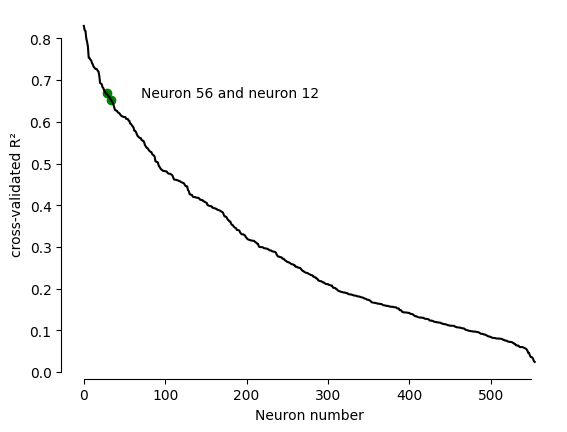

In [8]:
average_r2 = np.mean(r_squared, axis=0)
idx = np.argsort(average_r2)[::-1]
example_neuron_idx = [np.where(idx==56)[0][0], np.where(idx==12)[0][0]]

ax = plt.figure().add_subplot(111)
ax.plot(average_r2[idx], color = 'k')
ax.scatter(example_neuron_idx, average_r2[[56,12]], color = 'g')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_bounds([0,0.8])
ax.spines['bottom'].set_bounds([0,550])
ax.set_xlabel('Neuron number')
ax.set_ylabel('cross-validated R\u00b2') 
ax.text(70, 0.66, 'Neuron 56 and neuron 12')


## Exercise 4: Plot the choice and previous choice encoding over the trial duration as estimated by the encoding model

In addition to looking at the variance explained for each neuron, we can also plot the $\beta$ weights to see how particular regressors influence neural activity.
The aim of the final exercise of this notebook is to visualize the estimated weights for the previous choice and choice regressors across trial time.

- Average the beta weights of the different fold to generate the mean weights. Name this `average_beta`.
- Using what you've learned about the structure of the design matrix retrieve the beta weights for choice and previous choice over the trial duration
- Visualize the beta weights for these regressors

In [9]:
# 1. Start by getting the average beta weights

#####################------------Solution-----#######################
average_beta = np.mean(betas, axis=0) #Fold are along axis 0
######################################################################

# 2. Retrieve the betas for time, choice and previous choice and name them choice_betas and previous_choice_betas. Make sure
#    to build these varaibles so that the trial times are rows and the columns are neurons.

######################----------Solution-----------################
time_betas = average_beta[:, 0 : 1 * frames_per_trial].T
choice_betas = average_beta[:,frames_per_trial : 2*frames_per_trial].T
previous_choice_betas = average_beta[:,4*frames_per_trial : 5*frames_per_trial].T
###########################################################################################

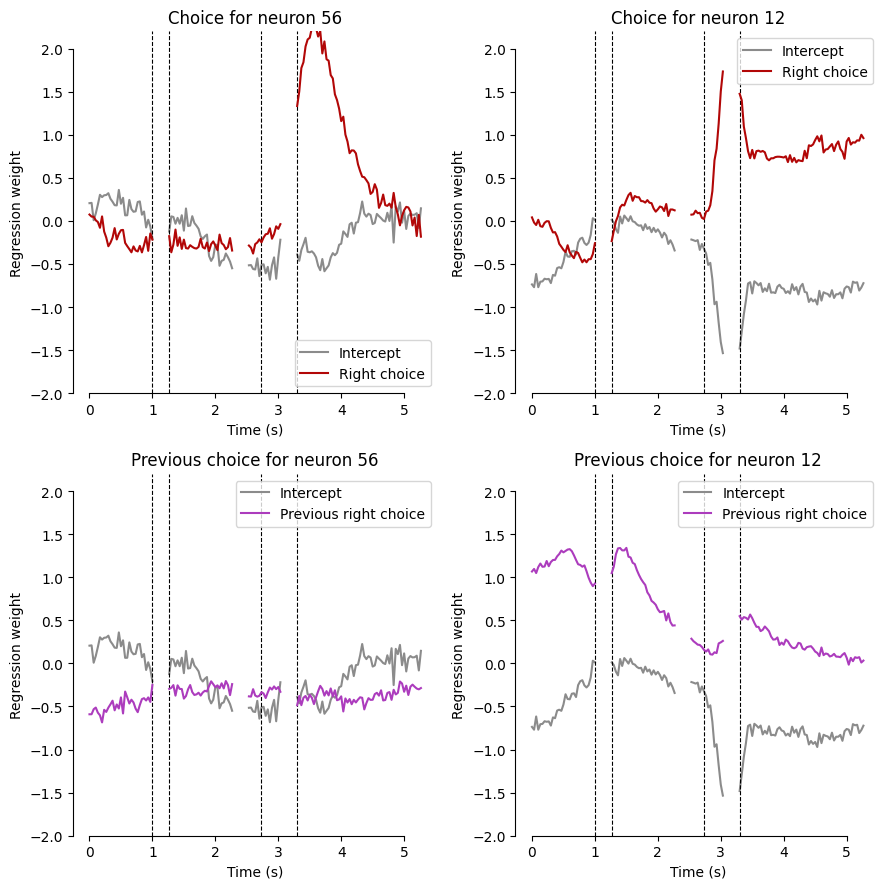

In [10]:
#First create a figure with four subplots
axes_list = encoding_tools.create_subplot_axes(2, 2, fig_size=(9,9))

#Now we can fill the subplots
encoding_tools.plot_task_var_betas(choice_betas, time_betas, 'Choice', 56, aligned_segment_start, axes_list[0], colors = ['#8b8b8b', '#b20707'], var_value_strings = ['Intercept', 'Right choice'])
encoding_tools.plot_task_var_betas(choice_betas, time_betas, 'Choice', 12, aligned_segment_start, axes_list[1], colors = ['#8b8b8b', '#b20707'], var_value_strings = ['Intercept', 'Right choice'])
encoding_tools.plot_task_var_betas(previous_choice_betas, time_betas, 'Previous choice', 56, aligned_segment_start, axes_list[2], colors = ['#8b8b8b', '#ac3cbd'], var_value_strings = ['Intercept', 'Previous right choice'])
encoding_tools.plot_task_var_betas(previous_choice_betas, time_betas, 'Previous choice', 12, aligned_segment_start, axes_list[3], colors = ['#8b8b8b', '#ac3cbd'], var_value_strings = ['Intercept', 'Previous right choice'])
plt.tight_layout()

### Examine the plots above and discuss the following questions
- Why are the lines labeled Intercept represent?
- What is the interpretation of these lines and how would you reconstruct a PETH for a right choice trial from the regressor weights?
- Do these neurons mix encoding of different task variables?

## Sanity check: plotting PETH's

To make sure our model is performing as expected, lets also plot some peri-event time histograms (PETH's). We will divide up trials by left vs right choice or left vs right previous choice. We will then plot the average response +/- SEM. Based on the plots above, our neurons seem to be encoding choice and previous choice, so we should see a nice separation in left vs right choice when plotting the PETH's.

In [11]:
n_total_frames = design_matrix.shape[0] #total number of frames in the session

choice = design_matrix['choice_t0'][np.arange(0, n_total_frames, frames_per_trial)] 
previous_choice = design_matrix['previous_choice_t0'][np.arange(0, n_total_frames, frames_per_trial)]

choice = np.array(choice)
previous_choice = np.array(previous_choice)

# Reshape the flourescence data matrix to obtain a timepoints x neuron id x trial matrix.
n_neurons = Y_raw_fluorescence.shape[1]
n_trials = int(design_matrix.shape[0] / frames_per_trial)
Y_3d = np.reshape(Y_raw_fluorescence.T, (n_neurons, n_trials, frames_per_trial)).transpose(2,0,1)

print(f'The shape of the calcium signal matrix was {Y_raw_fluorescence.shape}')
print(f'The shape of the calcium signal matrix is now {Y_3d.shape}')

The shape of the calcium signal matrix was (47196, 555)
The shape of the calcium signal matrix is now (138, 555, 342)


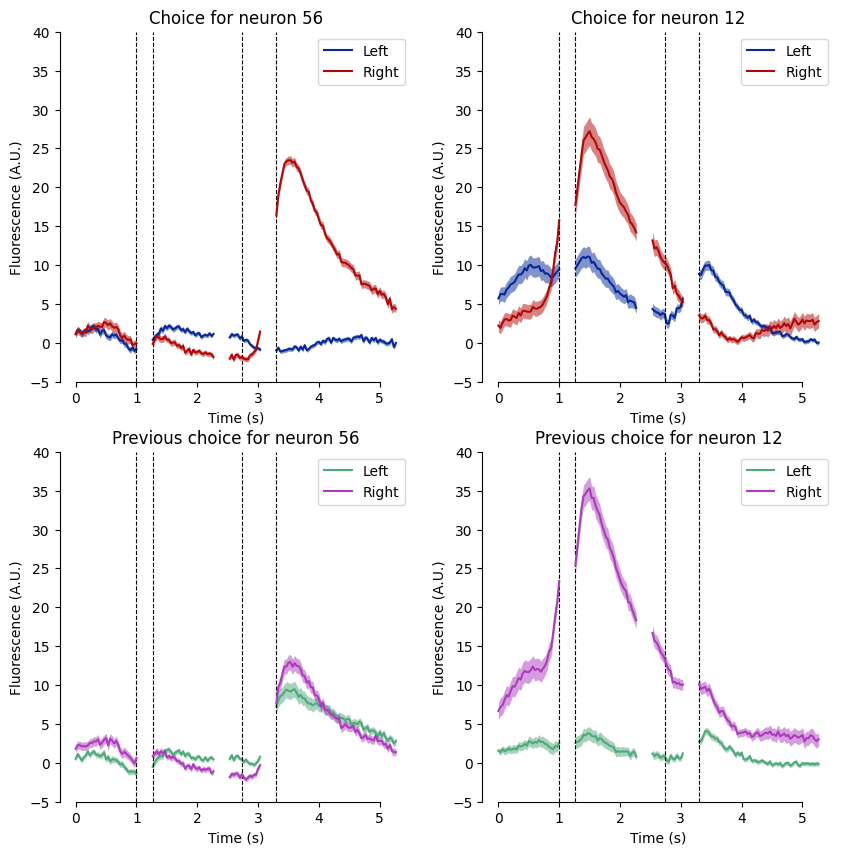

In [13]:
#Now lets call our function and plot the traces
#First create a figure with four subplots
axes_list = encoding_tools.create_subplot_axes(2, 2, fig_size=(10,10)) 

#Now we can fill the subplots
encoding_tools.plot_mean_trace(Y_3d, choice, 'Choice', 56, aligned_segment_start, axes_list[0])
encoding_tools.plot_mean_trace(Y_3d, choice, 'Choice', 12, aligned_segment_start, axes_list[1])
encoding_tools.plot_mean_trace(Y_3d, previous_choice, 'Previous choice', 56, aligned_segment_start, axes_list[2], colors = ['#4fa97a', '#ac3cbd'])
encoding_tools.plot_mean_trace(Y_3d, previous_choice, 'Previous choice', 12, aligned_segment_start, axes_list[3], colors = ['#4fa97a', '#ac3cbd'])

### Examine the plots and consider the following questions
- How do these PETH plots compare to the plots of the $\beta$ weights for choice and previous choice?
- If there are differences, why do you think that is?

In the next notebook, we will train the encoding model on shuffled versions of the design matrix. This will allow us to assess the variance that can be explained by individual task variables.